## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [7]:
import sys
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [8]:
# DESRES BBA
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein"
trj_file = []
for i in np.arange(0,10):
    fname = "1FME-1-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))

In [9]:
trj_file

['/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-000.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-001.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-002.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-003.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-004.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Lie

### mdtraj

In [10]:
trj_file

['/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-000.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-001.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-002.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-003.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Liew_LSS-20210125T201148Z-003/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/1FME-1-protein-004.dcd',
 '/media/joseph/Memorex USB/liew/Joe_Lie

In [11]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

NameError: name 'traj_obj' is not defined

## featurization

In [25]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

15-02-21 16:10:37 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[11] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 3744


In [26]:
data = np.zeros((0,features.dimension()))
for i in range(len(trj_file)):
    q = py.coordinates.load(trj_file[i], features=features)
    data = np.concatenate((data,q), axis=0)
    print(i)
    print(data.shape)

0
(10000, 3744)
1
(20000, 3744)
2
(30000, 3744)
3
(40000, 3744)
4
(50000, 3744)
5
(60000, 3744)
6
(70000, 3744)
7
(80000, 3744)
8
(90000, 3744)
9
(100000, 3744)


## (1) latent space projection

### parameters

In [27]:
lag=50
dim=5
is_reversible=True

### SRV

In [28]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [27]:
hde.fit(data)


Instructions for updating:
Use `tf.cast` instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300




99950/99950 [==============================] - 4s 40us/step - loss: -1.6612
Epoch 2/300
99950/99950 [==============================] - 1s 13us/step - loss: -1.9540
Epoch 3/300
99950/99950 [==============================] - 2s 15us/step - loss: -2.0186
Epoch 4/300
99950/99950 [==============================] - 1s 13us/step - loss: -2.0643
Epoch 5/300
99950/99950 [==============================] - 1s 12us/step - loss: -2.0990
Epoch 6/300
99950/99950 [==============================] - 1s 12us/step - loss: -2.1311
Epoch 7/300
99950/99950 [==============================] - 1s 12us/step - loss: -2.1612
Epoch 8/300
99950/99950 [==============================] - 1s 13us/step - loss: -2.2003
Epoch 9/300
99950/99950 [==============================] - 1s 12us/step - loss: -2.2563
Epoch 10/300
99950/99950 [============================

99950/99950 [==============================] - 1s 13us/step - loss: -4.2903
Epoch 154/300
99950/99950 [==============================] - 1s 14us/step - loss: -4.2817
Epoch 155/300
99950/99950 [==============================] - 1s 15us/step - loss: -4.2512
Epoch 156/300
99950/99950 [==============================] - 1s 13us/step - loss: -4.2773
Epoch 157/300
99950/99950 [==============================] - 1s 12us/step - loss: -4.2765
Epoch 158/300
99950/99950 [==============================] - 1s 13us/step - loss: -4.2796
Epoch 159/300
99950/99950 [==============================] - 1s 12us/step - loss: -4.2904
Epoch 160/300
99950/99950 [==============================] - 1s 15us/step - loss: -4.2771
Epoch 161/300
99950/99950 [==============================] - 1s 12us/step - loss: -4.3040
Epoch 162/300
99950/99950 [==============================] - 1s 13us/step - loss: -4.2926
Epoch 163/300
99950/99950 [==============================] - 1s 13us/step - loss: -4.2920
Epoch 164/300
99950/9995

HDE(activation=None, batch_normalization=True, batch_size=20000, callbacks=None,
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=505,
    l2_regularization=0.0, lag_time=50, latent_space_noise=0,
    learning_rate=0.0005, n_components=5, n_epochs=300, reversible=True,
    validation_split=0, verbose=True)

In [28]:
hde.callbacks = None
hde.history = None
pickle.dump(hde, open('hde.pkl', 'wb'), protocol=4)

In [18]:
hde = pickle.load(open('hde.pkl', 'rb'))

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
hde_coords = hde.transform(data, side='left')
#hde_coords_right = hde.transform(data, side='right')
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
#print(hde_coords_right)

[2236.12882294  765.65007723  326.43640881  262.5850587    64.39939175]
[[-1.2846831   0.06824613  0.17542922 -0.08290112 -0.08967659]
 [-1.1272044   0.23690188  0.07313311 -0.13291124 -0.26303613]
 [-1.2443206   0.03409252 -0.03372877 -0.18523636  0.06963325]
 ...
 [ 0.807818    0.0546469  -0.08550908  0.07781153 -2.658559  ]
 [ 0.8039169   0.11381578  0.03705215 -0.09049535 -2.2711368 ]
 [ 0.79700834  0.09892476  0.01752901  0.05058217 -2.4368203 ]]


### SRV k-means clustering

#### n_cluster optimization using silhouette score

- expect n_cluster = (dim_kmeans+1) similar to PCCA (# macrostates = 1 + # singular vectors)

- Idea of inner simplex (PCCA) clustering directly in singular vectors of transfer operator:
F. Paul, H. Wu, M. Vossel, B.L. de Groot, and F. Noe "Identification of kinetic order parameters
for non-equilibrium dynamics" J. Chem. Phys. 150, 164120 (2019); doi: 10.1063/1.5083627

- k-means simpler and only for understanding of macrostates not construction of MSM

In [35]:
dim_kmeans = 2
hde_coords_kmeans = copy.deepcopy(hde_coords[:,:dim_kmeans])

In [36]:
range_n_clusters = np.arange(2,5,1)
silhouette_avg_array = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=200184)
    cluster_labels = clusterer.fit_predict(hde_coords_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(hde_coords_kmeans, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_array.append(silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.9368133
For n_clusters = 3 The average silhouette_score is : 0.97224015
For n_clusters = 4 The average silhouette_score is : 0.97277343


In [37]:
n_clusters = dim_kmeans+1 # usually, but check silhouette scores

In [38]:
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(hde_coords_kmeans)
centers = clusterer.cluster_centers_
sample_silhouette_values = silhouette_samples(hde_coords_kmeans, cluster_labels)

#### visualizing configs proximate to k-means centers

In [44]:
centers

array([[  0.77797747,   0.05332388],
       [ -0.23014419, -14.097703  ],
       [ -1.2877157 ,   0.09130473]], dtype=float32)

In [45]:
kmeans_viz = []
for i in range(n_clusters):
    idx_sort = np.argsort(np.sqrt(np.sum((hde_coords_kmeans - centers[i,:])**2, axis=1)))
    kmeans_viz.append(idx_sort[:10])

In [47]:
for i in range(n_clusters):
    print(hde_coords_kmeans[kmeans_viz[i][0],:])

[0.7779091  0.05326219]
[ -0.2184543 -14.149699 ]
[-1.2876202   0.09159555]


In [48]:
clust_id = 0
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

In [49]:
clust_id = 1
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

In [50]:
clust_id = 2
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

## (2) propagator

In [40]:
dim_prop = 2

In [41]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [42]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [43]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [44]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [45]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [58]:
from hde.propagator import get_mixture_loss_func

In [59]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [60]:
if is_reversible:
    prop.fit([traj_prop_scaled, traj_prop_scaled[::-1]]) # reversible -- data augmentation with inverted trajectory
else:
    prop.fit(traj_prop_scaled)

Train on 199900 samples
Epoch 1/20000
199900/199900 [==============================] - 2s 8us/sample - loss: 1.9888
Epoch 2/20000
199900/199900 [==============================] - 1s 3us/sample - loss: 1.9868
Epoch 3/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9849
Epoch 4/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9829
Epoch 5/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9809
Epoch 6/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9789
Epoch 7/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9769
Epoch 8/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9749
Epoch 9/20000
199900/199900 [==============================] - 1s 3us/sample - loss: 1.9729
Epoch 10/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 1.9709
Epoch 11/20000
199900/199900 [=========================

KeyboardInterrupt: 

In [62]:
pickle.dump(prop.model.get_weights(), open('prop_weights.pkl', 'wb'))

In [46]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [62]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

## (3) generator

#### x_train = scaled latent space coordinates

In [65]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [66]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [67]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 100000 frames, 10 atoms, 10 residues, and unitcells at 0x7f7f68129908>

In [68]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

NGLWidget(count=2000)

In [69]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [70]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [71]:
y_train = xyz_scaler.fit_transform(xyz)

In [72]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [73]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               10600     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                6030      
Total params: 56,830
Trainable params: 56,830
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               6600      
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_

In [7]:
#molgen.fit(x_train, y_train)

In [87]:
#molgen.fit(x_train, y_train) reason called twice?

0 [D loss: -0.044414] [G loss: -1.262821]
1 [D loss: -0.043956] [G loss: -1.220659]
2 [D loss: -0.045763] [G loss: -1.252606]
3 [D loss: -0.046646] [G loss: -1.193414]
4 [D loss: -0.043307] [G loss: -1.258219]
5 [D loss: -0.044686] [G loss: -1.215695]
6 [D loss: -0.043297] [G loss: -1.253367]
7 [D loss: -0.044377] [G loss: -1.211911]
8 [D loss: -0.044217] [G loss: -1.258666]
9 [D loss: -0.044947] [G loss: -1.205245]
10 [D loss: -0.043125] [G loss: -1.244560]
11 [D loss: -0.044925] [G loss: -1.203000]
12 [D loss: -0.043627] [G loss: -1.248700]
13 [D loss: -0.044560] [G loss: -1.212236]
14 [D loss: -0.042990] [G loss: -1.251996]
15 [D loss: -0.045792] [G loss: -1.215821]
16 [D loss: -0.043401] [G loss: -1.227608]
17 [D loss: -0.043627] [G loss: -1.213568]
18 [D loss: -0.043329] [G loss: -1.260539]
19 [D loss: -0.045102] [G loss: -1.210447]
20 [D loss: -0.043725] [G loss: -1.242474]
21 [D loss: -0.042462] [G loss: -1.209476]
22 [D loss: -0.043756] [G loss: -1.239421]
23 [D loss: -0.042978

189 [D loss: -0.038479] [G loss: -1.179035]
190 [D loss: -0.036427] [G loss: -1.218096]
191 [D loss: -0.039267] [G loss: -1.161635]
192 [D loss: -0.036573] [G loss: -1.212838]
193 [D loss: -0.037072] [G loss: -1.149156]
194 [D loss: -0.037559] [G loss: -1.233144]
195 [D loss: -0.038130] [G loss: -1.160780]
196 [D loss: -0.037246] [G loss: -1.230224]
197 [D loss: -0.036475] [G loss: -1.158491]
198 [D loss: -0.038473] [G loss: -1.209242]
199 [D loss: -0.037382] [G loss: -1.155398]
200 [D loss: -0.037607] [G loss: -1.219469]
201 [D loss: -0.039755] [G loss: -1.168324]
202 [D loss: -0.038055] [G loss: -1.202868]
203 [D loss: -0.037643] [G loss: -1.161729]
204 [D loss: -0.036012] [G loss: -1.206351]
205 [D loss: -0.037655] [G loss: -1.160401]
206 [D loss: -0.036048] [G loss: -1.222710]
207 [D loss: -0.036705] [G loss: -1.168210]
208 [D loss: -0.037370] [G loss: -1.224080]
209 [D loss: -0.038896] [G loss: -1.150803]
210 [D loss: -0.036437] [G loss: -1.215374]
211 [D loss: -0.037004] [G loss:

376 [D loss: -0.033705] [G loss: -1.201859]
377 [D loss: -0.034389] [G loss: -1.160224]
378 [D loss: -0.033497] [G loss: -1.191584]
379 [D loss: -0.033805] [G loss: -1.127985]
380 [D loss: -0.035117] [G loss: -1.221882]
381 [D loss: -0.034471] [G loss: -1.130934]
382 [D loss: -0.034887] [G loss: -1.203070]
383 [D loss: -0.033365] [G loss: -1.134752]
384 [D loss: -0.033958] [G loss: -1.204471]
385 [D loss: -0.035120] [G loss: -1.135912]
386 [D loss: -0.034183] [G loss: -1.203624]
387 [D loss: -0.033872] [G loss: -1.133071]
388 [D loss: -0.033413] [G loss: -1.217085]
389 [D loss: -0.034935] [G loss: -1.130016]
390 [D loss: -0.034535] [G loss: -1.192679]
391 [D loss: -0.032866] [G loss: -1.144975]
392 [D loss: -0.033923] [G loss: -1.201916]
393 [D loss: -0.034160] [G loss: -1.145097]
394 [D loss: -0.031814] [G loss: -1.171874]
395 [D loss: -0.034939] [G loss: -1.152053]
396 [D loss: -0.034095] [G loss: -1.209852]
397 [D loss: -0.034350] [G loss: -1.153331]
398 [D loss: -0.033810] [G loss:

563 [D loss: -0.033995] [G loss: -1.161363]
564 [D loss: -0.032744] [G loss: -1.220259]
565 [D loss: -0.033981] [G loss: -1.148204]
566 [D loss: -0.032563] [G loss: -1.215166]
567 [D loss: -0.033200] [G loss: -1.168338]
568 [D loss: -0.034226] [G loss: -1.225749]
569 [D loss: -0.033796] [G loss: -1.163441]
570 [D loss: -0.033431] [G loss: -1.228259]
571 [D loss: -0.033275] [G loss: -1.154587]
572 [D loss: -0.033430] [G loss: -1.221557]
573 [D loss: -0.032612] [G loss: -1.168012]
574 [D loss: -0.031465] [G loss: -1.211504]
575 [D loss: -0.033969] [G loss: -1.164119]
576 [D loss: -0.032045] [G loss: -1.199505]
577 [D loss: -0.033024] [G loss: -1.175491]
578 [D loss: -0.033349] [G loss: -1.200613]
579 [D loss: -0.033786] [G loss: -1.179576]
580 [D loss: -0.033579] [G loss: -1.218639]
581 [D loss: -0.033099] [G loss: -1.161578]
582 [D loss: -0.032033] [G loss: -1.233873]
583 [D loss: -0.033395] [G loss: -1.147282]
584 [D loss: -0.032156] [G loss: -1.243533]
585 [D loss: -0.032571] [G loss:

750 [D loss: -0.031713] [G loss: -1.196910]
751 [D loss: -0.031698] [G loss: -1.143979]
752 [D loss: -0.031908] [G loss: -1.205853]
753 [D loss: -0.032328] [G loss: -1.159369]
754 [D loss: -0.031319] [G loss: -1.200561]
755 [D loss: -0.031672] [G loss: -1.142468]
756 [D loss: -0.032260] [G loss: -1.200086]
757 [D loss: -0.031349] [G loss: -1.143255]
758 [D loss: -0.030955] [G loss: -1.192208]
759 [D loss: -0.032250] [G loss: -1.149978]
760 [D loss: -0.032387] [G loss: -1.191908]
761 [D loss: -0.031364] [G loss: -1.145461]
762 [D loss: -0.031350] [G loss: -1.192317]
763 [D loss: -0.032580] [G loss: -1.135013]
764 [D loss: -0.030024] [G loss: -1.209364]
765 [D loss: -0.032988] [G loss: -1.149400]
766 [D loss: -0.030821] [G loss: -1.209354]
767 [D loss: -0.032813] [G loss: -1.140062]
768 [D loss: -0.029539] [G loss: -1.203668]
769 [D loss: -0.032570] [G loss: -1.130359]
770 [D loss: -0.031326] [G loss: -1.193234]
771 [D loss: -0.031314] [G loss: -1.146420]
772 [D loss: -0.031759] [G loss:

937 [D loss: -0.030497] [G loss: -1.112492]
938 [D loss: -0.028900] [G loss: -1.155705]
939 [D loss: -0.029771] [G loss: -1.101563]
940 [D loss: -0.028545] [G loss: -1.152035]
941 [D loss: -0.030216] [G loss: -1.087708]
942 [D loss: -0.028962] [G loss: -1.184616]
943 [D loss: -0.030062] [G loss: -1.071244]
944 [D loss: -0.029896] [G loss: -1.164131]
945 [D loss: -0.030777] [G loss: -1.095765]
946 [D loss: -0.029633] [G loss: -1.142290]
947 [D loss: -0.029812] [G loss: -1.105346]
948 [D loss: -0.029471] [G loss: -1.145508]
949 [D loss: -0.030487] [G loss: -1.099609]
950 [D loss: -0.029127] [G loss: -1.146772]
951 [D loss: -0.029812] [G loss: -1.122115]
952 [D loss: -0.029321] [G loss: -1.165083]
953 [D loss: -0.030064] [G loss: -1.091113]
954 [D loss: -0.027217] [G loss: -1.147040]
955 [D loss: -0.029118] [G loss: -1.096298]
956 [D loss: -0.029819] [G loss: -1.141113]
957 [D loss: -0.028574] [G loss: -1.097169]
958 [D loss: -0.029432] [G loss: -1.178509]
959 [D loss: -0.029891] [G loss:

1121 [D loss: -0.028997] [G loss: -1.075855]
1122 [D loss: -0.027062] [G loss: -1.091733]
1123 [D loss: -0.028684] [G loss: -1.080371]
1124 [D loss: -0.026640] [G loss: -1.083054]
1125 [D loss: -0.027004] [G loss: -1.069288]
1126 [D loss: -0.027664] [G loss: -1.107956]
1127 [D loss: -0.028536] [G loss: -1.061630]
1128 [D loss: -0.027632] [G loss: -1.114883]
1129 [D loss: -0.026784] [G loss: -1.078628]
1130 [D loss: -0.026620] [G loss: -1.107178]
1131 [D loss: -0.028668] [G loss: -1.030444]
1132 [D loss: -0.028141] [G loss: -1.137618]
1133 [D loss: -0.026321] [G loss: -1.040967]
1134 [D loss: -0.028229] [G loss: -1.128219]
1135 [D loss: -0.028263] [G loss: -1.037049]
1136 [D loss: -0.028342] [G loss: -1.102372]
1137 [D loss: -0.026952] [G loss: -1.058337]
1138 [D loss: -0.026473] [G loss: -1.087643]
1139 [D loss: -0.027881] [G loss: -1.071407]
1140 [D loss: -0.027167] [G loss: -1.095273]
1141 [D loss: -0.028285] [G loss: -1.070874]
1142 [D loss: -0.027519] [G loss: -1.101195]
1143 [D lo

1304 [D loss: -0.025552] [G loss: -1.046878]
1305 [D loss: -0.026069] [G loss: -1.023866]
1306 [D loss: -0.026601] [G loss: -1.045212]
1307 [D loss: -0.025972] [G loss: -1.019469]
1308 [D loss: -0.026129] [G loss: -1.055848]
1309 [D loss: -0.025643] [G loss: -1.010392]
1310 [D loss: -0.026374] [G loss: -1.053037]
1311 [D loss: -0.026161] [G loss: -1.009630]
1312 [D loss: -0.026238] [G loss: -1.058823]
1313 [D loss: -0.025939] [G loss: -1.009889]
1314 [D loss: -0.025920] [G loss: -1.080521]
1315 [D loss: -0.024908] [G loss: -1.004195]
1316 [D loss: -0.026422] [G loss: -1.075455]
1317 [D loss: -0.026766] [G loss: -0.986101]
1318 [D loss: -0.025331] [G loss: -1.063778]
1319 [D loss: -0.026508] [G loss: -1.005053]
1320 [D loss: -0.027182] [G loss: -1.062760]
1321 [D loss: -0.026017] [G loss: -0.986512]
1322 [D loss: -0.026821] [G loss: -1.061756]
1323 [D loss: -0.026328] [G loss: -1.001208]
1324 [D loss: -0.026614] [G loss: -1.058408]
1325 [D loss: -0.025037] [G loss: -1.024045]
1326 [D lo

1487 [D loss: -0.023546] [G loss: -0.975816]
1488 [D loss: -0.023532] [G loss: -1.043949]
1489 [D loss: -0.023761] [G loss: -0.984697]
1490 [D loss: -0.023481] [G loss: -1.004777]
1491 [D loss: -0.023950] [G loss: -0.971252]
1492 [D loss: -0.022894] [G loss: -1.030514]
1493 [D loss: -0.024581] [G loss: -0.983097]
1494 [D loss: -0.024208] [G loss: -1.016965]
1495 [D loss: -0.024512] [G loss: -0.998902]
1496 [D loss: -0.022336] [G loss: -1.010067]
1497 [D loss: -0.024610] [G loss: -0.981996]
1498 [D loss: -0.022814] [G loss: -1.020370]
1499 [D loss: -0.022550] [G loss: -0.988224]
1500 [D loss: -0.023412] [G loss: -1.024003]
1501 [D loss: -0.023281] [G loss: -0.982667]
1502 [D loss: -0.023298] [G loss: -1.014784]
1503 [D loss: -0.022933] [G loss: -0.958117]
1504 [D loss: -0.022435] [G loss: -1.029236]
1505 [D loss: -0.025046] [G loss: -0.981937]
1506 [D loss: -0.024456] [G loss: -1.029129]
1507 [D loss: -0.022900] [G loss: -0.974733]
1508 [D loss: -0.024268] [G loss: -1.013656]
1509 [D lo

1670 [D loss: -0.021326] [G loss: -0.997005]
1671 [D loss: -0.022860] [G loss: -0.978576]
1672 [D loss: -0.022472] [G loss: -0.988339]
1673 [D loss: -0.022224] [G loss: -0.972164]
1674 [D loss: -0.021178] [G loss: -1.024414]
1675 [D loss: -0.022585] [G loss: -0.980970]
1676 [D loss: -0.022675] [G loss: -0.977359]
1677 [D loss: -0.022594] [G loss: -0.985042]
1678 [D loss: -0.024471] [G loss: -1.011780]
1679 [D loss: -0.021670] [G loss: -0.957881]
1680 [D loss: -0.021676] [G loss: -1.034226]
1681 [D loss: -0.022219] [G loss: -0.949281]
1682 [D loss: -0.021118] [G loss: -1.002821]
1683 [D loss: -0.023602] [G loss: -0.967284]
1684 [D loss: -0.022395] [G loss: -1.007463]
1685 [D loss: -0.021704] [G loss: -0.974413]
1686 [D loss: -0.022701] [G loss: -0.990539]
1687 [D loss: -0.022149] [G loss: -0.977096]
1688 [D loss: -0.021937] [G loss: -1.000672]
1689 [D loss: -0.021754] [G loss: -0.971663]
1690 [D loss: -0.021387] [G loss: -1.013432]
1691 [D loss: -0.022665] [G loss: -0.979967]
1692 [D lo

1853 [D loss: -0.019839] [G loss: -0.947008]
1854 [D loss: -0.020735] [G loss: -1.008481]
1855 [D loss: -0.020040] [G loss: -0.947188]
1856 [D loss: -0.022637] [G loss: -0.998828]
1857 [D loss: -0.020370] [G loss: -0.967345]
1858 [D loss: -0.019233] [G loss: -0.995682]
1859 [D loss: -0.020492] [G loss: -0.980055]
1860 [D loss: -0.021097] [G loss: -1.013976]
1861 [D loss: -0.019988] [G loss: -0.940508]
1862 [D loss: -0.019739] [G loss: -1.001891]
1863 [D loss: -0.020681] [G loss: -0.964677]
1864 [D loss: -0.020526] [G loss: -1.014941]
1865 [D loss: -0.020857] [G loss: -0.964460]
1866 [D loss: -0.020789] [G loss: -1.000016]
1867 [D loss: -0.021011] [G loss: -0.974595]
1868 [D loss: -0.021214] [G loss: -0.975512]
1869 [D loss: -0.019452] [G loss: -0.978072]
1870 [D loss: -0.020640] [G loss: -0.981014]
1871 [D loss: -0.019050] [G loss: -0.964402]
1872 [D loss: -0.019940] [G loss: -0.994877]
1873 [D loss: -0.020665] [G loss: -0.946045]
1874 [D loss: -0.020738] [G loss: -0.996212]
1875 [D lo

2036 [D loss: -0.018635] [G loss: -0.981859]
2037 [D loss: -0.018769] [G loss: -0.963075]
2038 [D loss: -0.017399] [G loss: -0.964308]
2039 [D loss: -0.019799] [G loss: -0.957353]
2040 [D loss: -0.018815] [G loss: -0.969295]
2041 [D loss: -0.018270] [G loss: -0.933881]
2042 [D loss: -0.018704] [G loss: -0.981706]
2043 [D loss: -0.020320] [G loss: -0.954848]
2044 [D loss: -0.018191] [G loss: -0.953975]
2045 [D loss: -0.018718] [G loss: -0.950788]
2046 [D loss: -0.018568] [G loss: -0.982418]
2047 [D loss: -0.018901] [G loss: -0.930664]
2048 [D loss: -0.017307] [G loss: -0.975420]
2049 [D loss: -0.017936] [G loss: -0.942976]
2050 [D loss: -0.018474] [G loss: -0.958554]
2051 [D loss: -0.018219] [G loss: -0.939195]
2052 [D loss: -0.018016] [G loss: -0.986620]
2053 [D loss: -0.018163] [G loss: -0.948918]
2054 [D loss: -0.018736] [G loss: -0.946288]
2055 [D loss: -0.018843] [G loss: -0.958744]
2056 [D loss: -0.018900] [G loss: -0.964843]
2057 [D loss: -0.017751] [G loss: -0.944472]
2058 [D lo

2219 [D loss: -0.017666] [G loss: -0.891949]
2220 [D loss: -0.017971] [G loss: -0.930424]
2221 [D loss: -0.017182] [G loss: -0.907212]
2222 [D loss: -0.017239] [G loss: -0.926083]
2223 [D loss: -0.017874] [G loss: -0.899292]
2224 [D loss: -0.017757] [G loss: -0.940248]
2225 [D loss: -0.018672] [G loss: -0.916133]
2226 [D loss: -0.019181] [G loss: -0.912153]
2227 [D loss: -0.017530] [G loss: -0.931684]
2228 [D loss: -0.017727] [G loss: -0.905073]
2229 [D loss: -0.017533] [G loss: -0.925908]
2230 [D loss: -0.018639] [G loss: -0.934402]
2231 [D loss: -0.017607] [G loss: -0.902815]
2232 [D loss: -0.018282] [G loss: -0.923343]
2233 [D loss: -0.017866] [G loss: -0.913147]
2234 [D loss: -0.017522] [G loss: -0.956482]
2235 [D loss: -0.018013] [G loss: -0.895770]
2236 [D loss: -0.017488] [G loss: -0.938764]
2237 [D loss: -0.017869] [G loss: -0.903443]
2238 [D loss: -0.018904] [G loss: -0.935913]
2239 [D loss: -0.017820] [G loss: -0.907895]
2240 [D loss: -0.019181] [G loss: -0.912048]
2241 [D lo

2402 [D loss: -0.018008] [G loss: -0.903747]
2403 [D loss: -0.016261] [G loss: -0.877686]
2404 [D loss: -0.017148] [G loss: -0.880066]
2405 [D loss: -0.017171] [G loss: -0.882525]
2406 [D loss: -0.016126] [G loss: -0.873231]
2407 [D loss: -0.017417] [G loss: -0.880367]
2408 [D loss: -0.017522] [G loss: -0.924727]
2409 [D loss: -0.018088] [G loss: -0.868210]
2410 [D loss: -0.016149] [G loss: -0.894330]
2411 [D loss: -0.018331] [G loss: -0.887104]
2412 [D loss: -0.018571] [G loss: -0.867721]
2413 [D loss: -0.017394] [G loss: -0.901166]
2414 [D loss: -0.017323] [G loss: -0.887753]
2415 [D loss: -0.016878] [G loss: -0.894833]
2416 [D loss: -0.016946] [G loss: -0.860737]
2417 [D loss: -0.017403] [G loss: -0.907302]
2418 [D loss: -0.017119] [G loss: -0.892452]
2419 [D loss: -0.018841] [G loss: -0.888427]
2420 [D loss: -0.017668] [G loss: -0.884076]
2421 [D loss: -0.017636] [G loss: -0.879760]
2422 [D loss: -0.017926] [G loss: -0.911118]
2423 [D loss: -0.018018] [G loss: -0.873661]
2424 [D lo

MolGen(activation='swish', batch_size=30000, hidden_layer_depth=2,
       hidden_size=200, latent_dim=2, n_discriminator=5, n_epochs=2500,
       noise_dim=50, output_dim=30, verbose=True)

In [84]:
#molgen.generator.save('molgen_generator.h5')

In [85]:
#molgen.discriminator.save('molgen_discriminator.h5')

In [89]:
def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted # need to override after loading to allow molgen.transform to proceed


True

#### decoding synthetic propagator trajectories

In [90]:
assert molgen.is_fitted == True

In [91]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [94]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [95]:
traj_ca[0].save_pdb('synth.pdb')

In [96]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [97]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [98]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

<mdtraj.Trajectory with 2000 frames, 10 atoms, 10 residues, without unitcells at 0x7ff0368b8630>

In [99]:
view = nv.show_mdtraj(traj_synth_obj)
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

NGLWidget(count=2000)

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [563]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [564]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [565]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

In [1]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

NameError: name 'plt' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

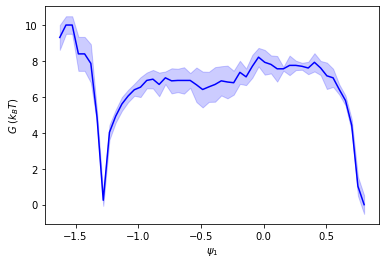

In [567]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [568]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [569]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [570]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

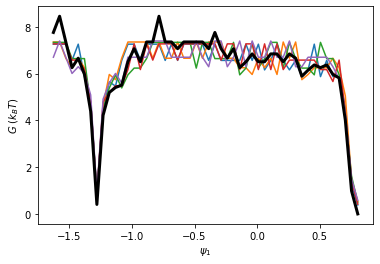

In [571]:
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, pmf_LSS, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

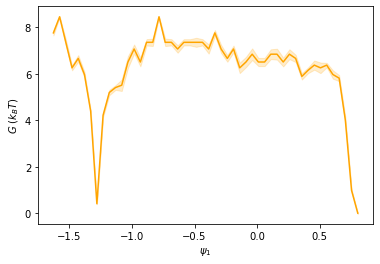

In [572]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

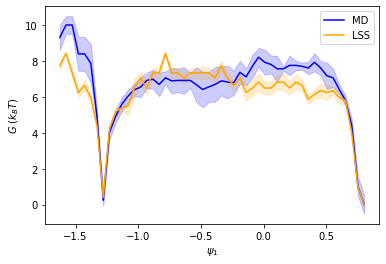

In [574]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

### kinetic (relaxation times)

In [302]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [303]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

In [304]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [305]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

MD relaxation times (ns) = 
441.372467 +/- 105.153030
154.753830 +/- 23.282644


In [306]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

In [575]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

/home/alf/anaconda3/envs/lss/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [576]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_synth[0,i], relax_synth_stderr[i]))

LSS relaxation times (ns) = 
232.088837 +/- 23.177208
4.624391 +/- nan


### structure (RMSD)

In [1]:
import MDAnalysis

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [4]:
MDAnalysis.rms.RMSD([0,1],[0,1])

AttributeError: module 'MDAnalysis' has no attribute 'rms'

In [5]:
md.join(t,t)

NameError: name 'md' is not defined